# Binary Classification Machine Learning. Case Study Loan Prediction

## 1 Problem Definition

The aim of this exercise is to use **Machine Learning** techniques to predict loan eligibility based on customer details. These details are numerical and categorical data that include information about gender, marital status, education, dependents, income, loan amount, credit history, and others. The label of each record is the letter `Y` if the loan is approved and `N` is the loan is rejected.

The training dataset contains the following information:

<table><tbody><tr><td width="155"><p><strong>Variable</strong></p></td><td width="465"><p>Description</p></td></tr><tr><td width="155"><p><strong>Loan_ID</strong></p></td><td width="465"><p>Unique Loan ID</p></td></tr><tr><td width="155"><p><strong>Gender</strong></p></td><td width="465"><p>Male/ Female</p></td></tr><tr><td width="155"><p><strong>Married</strong></p></td><td width="465"><p>Applicant married (Y/N)</p></td></tr><tr><td width="155"><p><strong>Dependents</strong></p></td><td width="465"><p>Number of dependents</p></td></tr><tr><td width="155"><p><strong>Education</strong></p></td><td width="465"><p>Applicant Education (Graduate/ Under Graduate)</p></td></tr><tr><td width="155"><p><strong>Self_Employed</strong></p></td><td width="465"><p>Self employed (Y/N)</p></td></tr><tr><td width="155"><p><strong>ApplicantIncome</strong></p></td><td width="465"><p>Applicant income</p></td></tr><tr><td width="155"><p><strong>CoapplicantIncome</strong></p></td><td width="465"><p>Coapplicant income</p></td></tr><tr><td width="155"><p><strong>LoanAmount</strong></p></td><td width="465"><p>Loan amount in thousands</p></td></tr><tr><td width="155"><p><strong>Loan_Amount_Term</strong></p></td><td width="465"><p>Term of loan in months</p></td></tr><tr><td width="155"><p><strong>Credit_History</strong></p></td><td width="465"><p>credit history meets guidelines</p></td></tr><tr><td width="155"><p><strong>Property_Area</strong></p></td><td width="465"><p>Urban/ Semi Urban/ Rural</p></td></tr><tr><td width="155"><p><strong>Loan_Status</strong></p></td><td width="465"><p>Loan approved (Y/N)</p></td></tr></tbody></table><p> 
    
The test dataset contains the same columns as the training dataset except the last one (Loan approved).

To solve this problem we will implement a Machine Learning solution based on data transformation and algorithm tuning to improve model performance. This solution is inspired by the recipes contained in the book [**Machine Learning Mastery With Python**](https://machinelearningmastery.com/machine-learning-with-python/) by Jason Brownlee [1].

## 2 Load the Dataset

First, we will load the required libraries to accomplish our goals.

In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

### 2.1 Loading training dataset

In [2]:
# load dataset
df = pd.read_csv('train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


According to the output, some columns have categorical data and other columns have numerical data.

## 3. Imputation of missing values for categorical and numerical values

As we do not want to reduce the amount of data for our Machine Learning solution, we need to fill null values with the most frequent one for each category in our data frame. But first, we will sum missing values for each column.

In [3]:
# sum missing values 
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We have seven columns with missing values. Next, we will impute both categorical and numerical values and change the data type of some columns.

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df = pd.DataFrame(imp.fit_transform(df),columns=df.columns,index=df.index)

In [5]:
df = df.astype({'ApplicantIncome': np.int64, 'CoapplicantIncome':float,
                'LoanAmount':float,'Loan_Amount_Term':float, 'Credit_History':float})

## 4. Transforming Categorical Data

In this section, we will transform categorical data because Machine Learning algorithm cannot deal with this type of data. 

First, we will get unique values from categorical columns.

In [6]:
print(df.Gender.unique(),
df.Married.unique(),
df.Dependents.unique(),
df.Education.unique(),
df.Self_Employed.unique(),
df.Property_Area.unique(),
df.Loan_Status.unique())

['Male' 'Female'] ['No' 'Yes'] ['0' '1' '2' '3+'] ['Graduate' 'Not Graduate'] ['No' 'Yes'] ['Urban' 'Rural' 'Semiurban'] ['Y' 'N']


Next, we will create and apply a function to generate the encoding scheme for categorical data and write back labels to the DataFrame. Based on [Dipanjan (DJ) Sarkar post]((https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63)).

In [50]:
from sklearn.preprocessing import LabelEncoder
def encoding_schema(df, cat, label):
    
    '''Function to generate the encoding scheme for categorical data and 
        write back labels to the DataFrame
    '''
    gle = LabelEncoder()
    cat_labels = gle.fit_transform(df[cat])
    cat_mappings = {index: label for index, label in enumerate(gle.classes_)}
    
    df[label] = cat_labels.astype('int64')
    
    return ('Labels for {} are {}'.format(cat, cat_mappings))

In [8]:
# apply encoding_scheme to Gender 
encoding_schema(df, 'Gender', 'GenderLabel')

"Labels for Gender are {0: 'Female', 1: 'Male'}"

In [9]:
# apply encoding_scheme to Married 
encoding_schema(df, 'Married', 'MarriedLabel')

"Labels for Married are {0: 'No', 1: 'Yes'}"

In [10]:
# apply encoding_scheme to Dependents
encoding_schema(df, 'Dependents', 'DependentsLabel')

"Labels for Dependents are {0: '0', 1: '1', 2: '2', 3: '3+'}"

In [11]:
# apply encoding_scheme to Education
encoding_schema(df, 'Education', 'EducationLabel')

"Labels for Education are {0: 'Graduate', 1: 'Not Graduate'}"

In [12]:
# apply encoding_scheme to Self_Employed
encoding_schema(df, 'Self_Employed', 'Self_EmployedLabel')

"Labels for Self_Employed are {0: 'No', 1: 'Yes'}"

In [13]:
# apply encoding_scheme to Property_Area
encoding_schema(df, 'Property_Area', 'Property_AreaLabel')

"Labels for Property_Area are {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}"

In [14]:
# apply encoding_scheme to Loan_Status
encoding_schema(df, 'Loan_Status', 'Loan_StatusLabel')

"Labels for Loan_Status are {0: 'N', 1: 'Y'}"

Finally, we will get rid of unuseful columns and rename back useful columns  

In [15]:
columns_to_keep  = ['Loan_ID', 'GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_AreaLabel', 'Loan_StatusLabel']

df = df[columns_to_keep]

In [16]:
old_colnames  = ['GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'Property_AreaLabel', 'Loan_StatusLabel']

new_colnames  = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status']

col_rename_dict = {i:j for i,j in zip(old_colnames,new_colnames)}
df = df.rename(columns=col_rename_dict)

## 5 Analyzing Data

After transforming our dataset, we can examine closely our data. 

### 5.1 Descriptive Statistics

Let's examine the number of rows and columns of our dataset.

In [17]:
# shape
df.shape

(614, 13)

We have 614 samples to produce our solution and we can observe that our dataset contains 13 attributes including the target attribute Loan_Status.

Now, let's look at the data type of each column.


In [18]:
df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object

Nearly all columns are numeric, some of them are real values (float) and others are integers (int).

Next, let's take a pick at the first 5 rows.

In [19]:
set_option('display.width', 100)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1,0,0,0,0,5849,0.0,120.0,360.0,1.0,2,1
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


Through the output, we can corroborate columns are numeric and some of them have different scales, so it is possible we need to transform them later on.

Next, we will summarize the distribution of each attribute.

In [20]:
set_option('precision', 3)
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000,614.000
mean,0.818,0.653,0.744,0.218,0.134,5403.459,1621.246,145.466,342.410,0.855,1.037,0.687
std,0.386,0.476,1.010,0.413,0.340,6109.042,2926.248,84.181,64.429,0.352,0.787,0.464
min,0.000,0.000,0.000,0.000,0.000,150.000,0.000,9.000,12.000,0.000,0.000,0.000
25%,1.000,0.000,0.000,0.000,0.000,2877.500,0.000,100.250,360.000,1.000,0.000,0.000
50%,1.000,1.000,0.000,0.000,0.000,3812.500,1188.500,125.000,360.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,0.000,0.000,5795.000,2297.250,164.750,360.000,1.000,2.000,1.000
max,1.000,1.000,3.000,1.000,1.000,81000.000,41667.000,700.000,480.000,1.000,2.000,1.000


We can observe our dataset has the same range, but they differ in mean values, so Standardization could be beneficial.

Let's see the class distribution from the Loan_Status

In [21]:
df.groupby(['Loan_Status']).size()

Loan_Status
0    192
1    422
dtype: int64

The class `Loans_Status` is imbalanced between YES(1) and NO(0)

### 5.2 Unimodal Data Visualizations

It is useful to look at our data through different visualization techniques in order to get insights about its distribution.

Let's plot a histogram to observe the dataset class distribution.

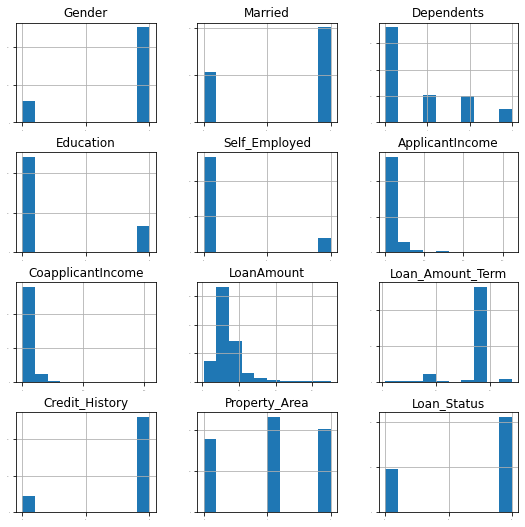

In [22]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(9,9))
plt.show();

We can see most of the class distributions are bimodal. For other attributes, the distribution is skewed right or skewed left and Gaussian-like.

We can observe easily this kind of distribution through [Density Plots](https://www.data-to-viz.com/graph/density.html#:~:text=A%20density%20plot%20is%20a,used%20in%20the%20same%20concept).

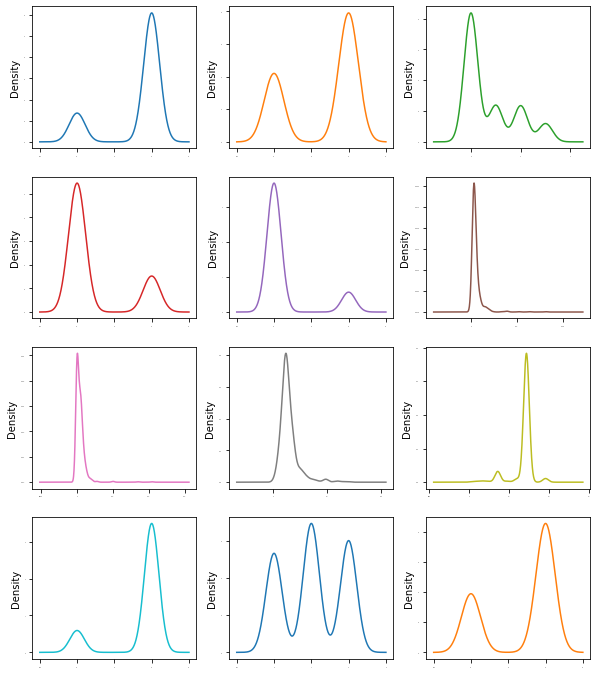

In [23]:
df.plot(kind='density', subplots=True, layout=(4,3), sharex=False, legend=False, fontsize=1, figsize=(10,12))
plt.show();

Let's look at the spread of attribute values using [whisker plots](https://en.wikipedia.org/wiki/Box_plot).  

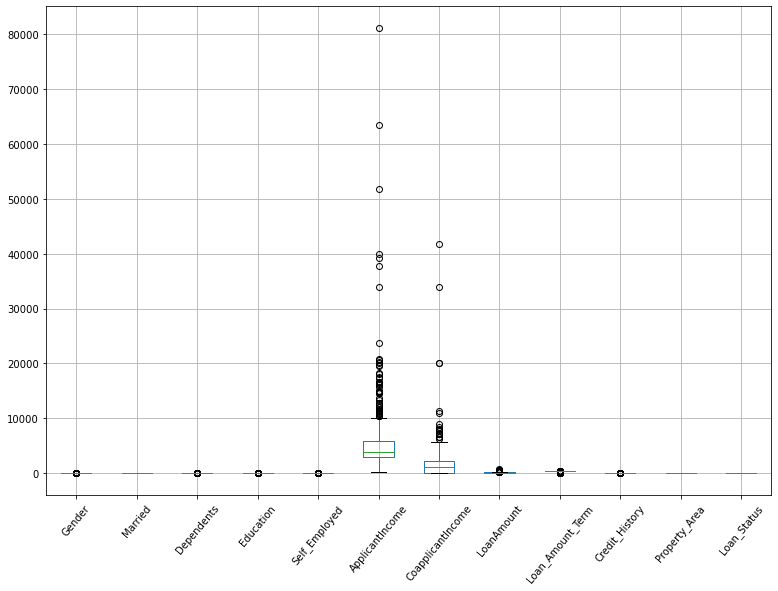

In [24]:
boxplot = df.boxplot(column=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status'], figsize=(13, 9), rot=50)

Except for `ApplicantIncome`(Applicant income) and `CoapplicantIncome`(Coapplicant income), the attributes are not spread. When modeling it is possible to get some benefits if we standardize in order to line up mean values.

## 6 Feature Selection


To shorten time computation and the performance of the Machine Learning Model we often prune the number of input features [2].

In this section, we will visualize the correlation between features through a [Heatmap](https://en.wikipedia.org/wiki/Heat_map).  A positive correlation means an increment in one value of a feature will increment the value of the target feature. On the other hand, a negative correlation means an increase in one value of a feature will decrease the value target feature [2].



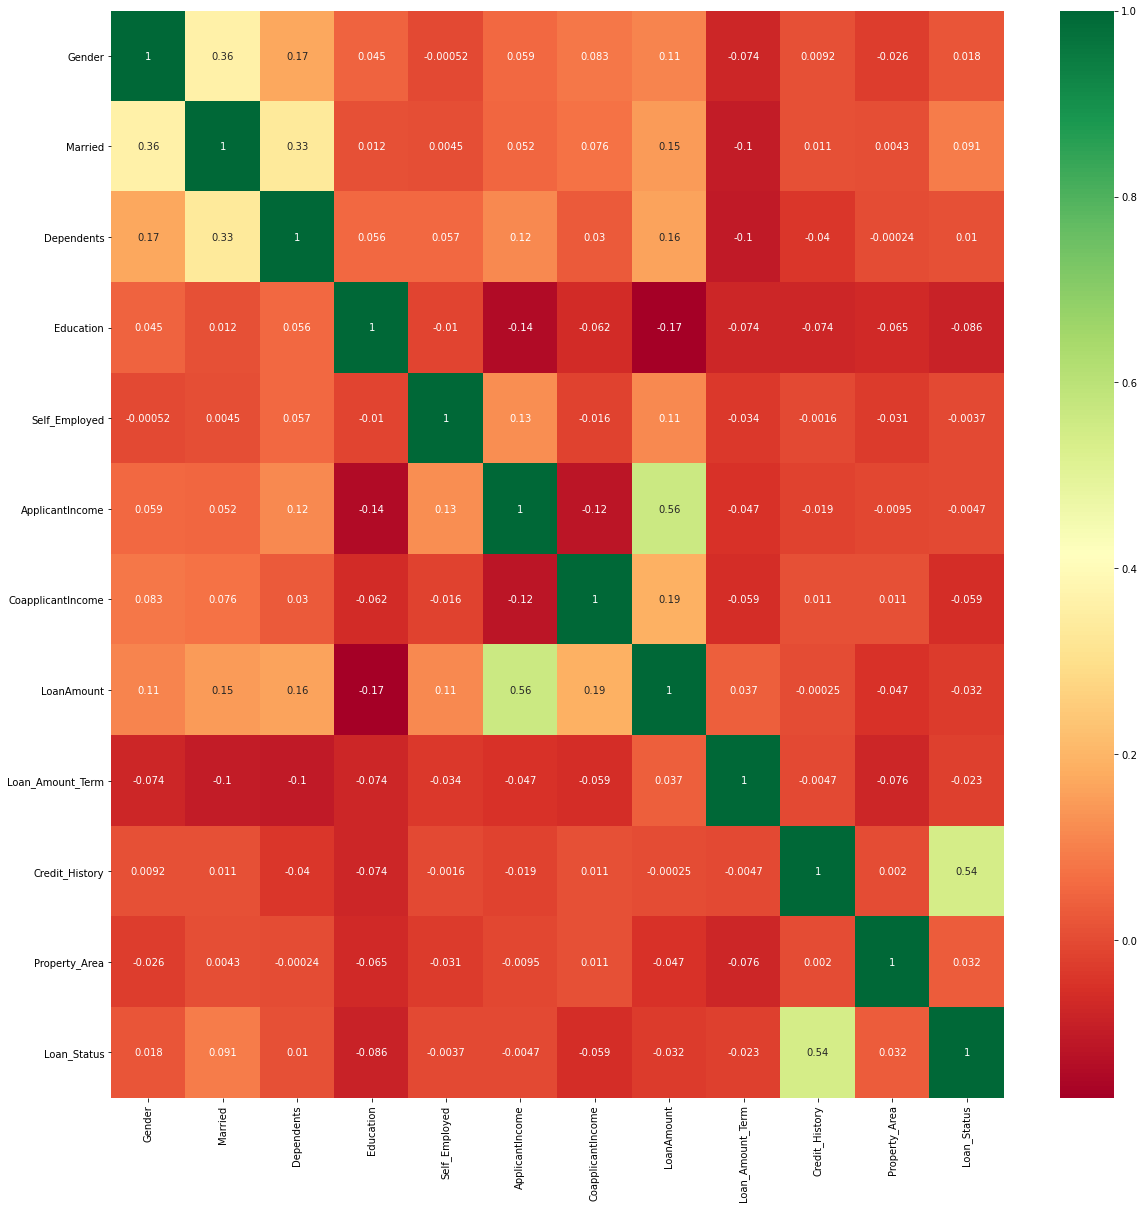

In [25]:
import seaborn as sns

X = df.iloc[:,1:12]  #independent column
y = df.iloc[:,12]    #target column

# get correlations of each features in dataset
corrmat = df.corr(method='pearson')
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn");

According to the output, the correlation between features is not significant, we will thus use all features to train the model.

### 6.1 Validation Dataset

Next, we will select a hold-out set. This dataset will be used to evaluate the performance of our model. We will use 70 % of our dataset for modeling and 30 % for validation

In [26]:
# replace values of the target features
df['Loan_Status'] = df.Loan_Status.replace({0: 'N', 1: 'Y'})

In [27]:
# split-out validation dataset
array = df.values
X = array[:, 1:12].astype(float)
Y = array[:, -1]
validation_size = 0.30
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

## 7 Evaluating Algorithms: Baseline

To evaluate Machine Learning algorithms and select the best one, we will design a test harness with 10-fold cross-validation, and accuracy as a performance metric

In [28]:
# test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

We will create a baseline in order to evaluate the performance of a set of algorithms capable of solving our problem.

The set of algorithms is as follows:

- ***Linear Algorithms:*** Logistic Regression (LR).
- ***Nonlinear Algorithms:*** Classification and Regression Trees (CART), Support Vector
Machines (SVM), Gaussian Naive Bayes (NB), and k-Nearest Neighbors (KNN).

In [29]:
# spot-check Algoriths
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [30]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.808915 (0.032245)
KNN: 0.631728 (0.059356)
CART: 0.671318 (0.045887)
NB: 0.787929 (0.023846)
SVM: 0.692193 (0.070921)


The above code snippet uses the default parameters of the selected algorithm and evaluates each algorithm based on its mean and standard deviation. According to the output, it is worth further studying `SVM` and `LR`.

Next, we will use Whisker plots to visualize the distribution of accuracy values calculated above.

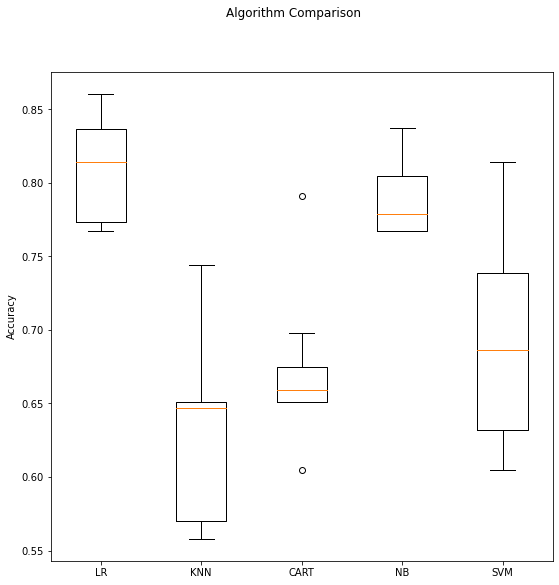

In [31]:
# compare algorithms 
fig = plt.figure(figsize=(9,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
plt.show();

The results show an almost similar distribution between `SVM` and `LR`, we can see the algorithm with less variance is `NB`, though.

## 8 Evaluating Algorithms: Standardize Data

We think varying distributions of the dataset are affecting the algorithm performance. So, we need to evaluate each algorithm based on a  [standardized](https://en.wikipedia.org/wiki/Feature_scaling) copy (SC) of the dataset. SC means each attribute has a mean of 0 and SD of 1. To do that we use pipelines that standardize the dataset, build the model for each fold in the [cross validation test](https://towardsdatascience.com/why-and-how-to-do-cross-validation-for-machine-learning-d5bd7e60c189). This procedure allows us to prevent data leakage and carry out a better estimation of the algorithm's performance.

In [35]:
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.811240 (0.034929)
ScaledKNN: 0.780731 (0.034462)
ScaledCART: 0.687542 (0.032606)
ScaledNB: 0.794906 (0.024752)
ScaledSVM: 0.792525 (0.038202)


The standardized method also points out that `SVM` and `LR` have the best performance. Next, we will plot the distributions of accuracy scores through box plots.

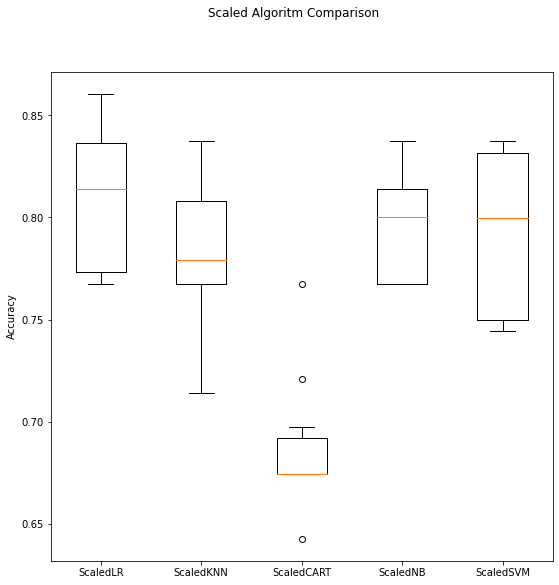

In [36]:
# compare algorithms
fig = plt.figure(figsize=(9,9))
fig.suptitle("Scaled Algoritm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
plt.show();

## 9 Algorithm Tuning

In this section, we will delve deeper into the parameters of `SVM` and `Logistic Regression` algorithms to enhance their performance.

### 9.1 Tuning SVM

We will begin by tunning the value of the regularization parameter `C`.  This parameter hinders learning complex models so that we can avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting) [4]. The higher the values of `C` the lower the regularization [5]. In other words, if the `C` parameter is high we end up adjusting our model to all point features, so our model is likely overfitting. We will also tune the Kernel function parameter, so the best Kernel parameter will have a high-class separability [6]

In [37]:
# tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.001, 0.01, 0.1, 1, 10]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean Test Score: %f, STD (%f) with: %r" % (mean, stdev, param))

Best score: 0.808915 using {'C': 0.01, 'kernel': 'linear'}
Mean Test Score: 0.694518, STD (0.074408) with: {'C': 0.001, 'kernel': 'linear'}
Mean Test Score: 0.696844, STD (0.071884) with: {'C': 0.001, 'kernel': 'poly'}
Mean Test Score: 0.694518, STD (0.074408) with: {'C': 0.001, 'kernel': 'rbf'}
Mean Test Score: 0.694518, STD (0.074408) with: {'C': 0.001, 'kernel': 'sigmoid'}
Mean Test Score: 0.808915, STD (0.043647) with: {'C': 0.01, 'kernel': 'linear'}
Mean Test Score: 0.696844, STD (0.071884) with: {'C': 0.01, 'kernel': 'poly'}
Mean Test Score: 0.694518, STD (0.074408) with: {'C': 0.01, 'kernel': 'rbf'}
Mean Test Score: 0.694518, STD (0.074408) with: {'C': 0.01, 'kernel': 'sigmoid'}
Mean Test Score: 0.808915, STD (0.043647) with: {'C': 0.1, 'kernel': 'linear'}
Mean Test Score: 0.764507, STD (0.048467) with: {'C': 0.1, 'kernel': 'poly'}
Mean Test Score: 0.745847, STD (0.059565) with: {'C': 0.1, 'kernel': 'rbf'}
Mean Test Score: 0.808915, STD (0.043647) with: {'C': 0.1, 'kernel': 'sig

According to the output, the best performance for the `SVC` has an accuracy of ***0.808915*** with a `C` parameter of **0.01** and a ***Linear*** Kernel.

### 9.2 Tuning Logistic Regression

Let's apply the same procedure to the Logistic Regression algorithm. But, in this case,  we will only tune the value of the regularization parameter `C`.

In [38]:
# tune scaled Logistic Regression
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=c_values, )
model = LogisticRegression(penalty='l2')
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean Test Score: %f, STD(%f) with: %r" % (mean, stdev, param))

Best score: 0.811240 using {'C': 0.1}
Mean Test Score: 0.694518, STD(0.074408) with: {'C': 0.001}
Mean Test Score: 0.808915, STD(0.043647) with: {'C': 0.01}
Mean Test Score: 0.811240, STD(0.034929) with: {'C': 0.1}
Mean Test Score: 0.811240, STD(0.034929) with: {'C': 1}
Mean Test Score: 0.811240, STD(0.034929) with: {'C': 10}


According to the output, the best performance for the `LogisticRegression` has an accuracy of **0.811240** with a `C` parameter of **0.1**. So we opt to use the **Logistic Regression** algorithm to build our prediction model.

## 10 Ensemble Methods

In this section we will combine various models in order to obtain the best predictive model, this technique is called **Ensemble Methods** [7]. 

We will test two [Boosting Methods](https://en.wikipedia.org/wiki/Boosting_(machine_learning)) and two [Bagging methods](https://en.wikipedia.org/wiki/Bootstrap_aggregating#:~:text=Bootstrap%20aggregating%2C%20also%20called%20bagging,and%20helps%20to%20avoid%20overfitting):

- Boosting Methods: AdaBoost (AB) and Gradient Boosting (GBM).
- Bagging Methods: Random Forests (RF) and Extra Trees (ET).

The same test schema will be used, 10-fold cross-validation. We will not standardize data because the ensemble methods we will use are based on decision trees,  that are less prone to be affected by the data distribution.

In [39]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Accuracy %s: %f,  STD(%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Accuracy AB: 0.773920,  STD(0.045239)
Accuracy GBM: 0.778571,  STD(0.039141)
Accuracy RF: 0.778571,  STD(0.027836)
Accuracy ET: 0.743632,  STD(0.017364)


Let's  plot the distributions of accuracy scores through box plots.

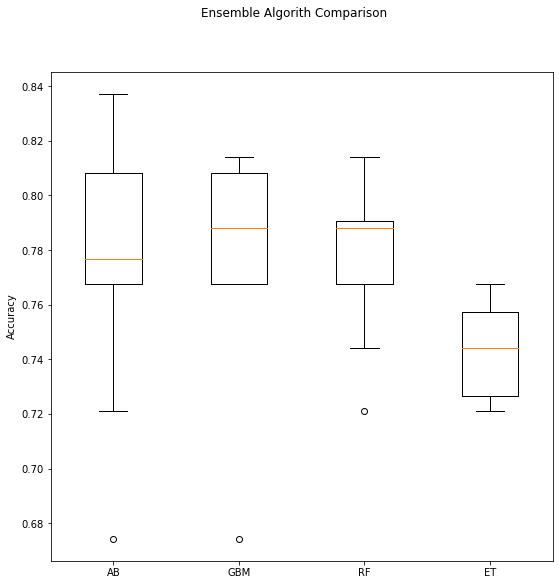

In [40]:
fig = plt.figure(figsize=(9,9))
fig.suptitle('Ensemble Algorith Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
plt.show();

According to the outputs, the performance of ensemble methods is no better than Linear Algorithms, so we will finalize our model with the ***Logistic Regression*** algorithm.

## 11 Finalizing  Model

Our findings show that the **Logistic Regression** model is less complex and more stable than the other tested models. In this section, we will train the **Logistic Regression** model for the whole dataset and make predictions for the validation dataset to see if our findings are also valid for the validation dataset. As before, this validation will be carried out on a standardized version of the test set.

In [41]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression(C= 0.1, penalty='l2')
model.fit(rescaledX, Y_train)

# estimate accuarcy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print('Accuracy Score:',round(accuracy_score(Y_validation, predictions), 2));

Accuracy Score: 0.81


We can see that **81%** of our predictions were correct. Now, let's create a table containing the classification report.

Next, we will create a data frame containing the classification report.

In [42]:
# generate classification report
cr = classification_report(Y_validation, predictions, output_dict=True)
dfcr = pd.DataFrame.from_dict(cr)
dfcr = dfcr[['N', 'Y']].T
dfcr = dfcr[['precision', 'recall', 'f1-score', 'support']]
dfcr

,precision,recall,f1-score,support
N,0.933,0.459,0.615,61.0
Y,0.787,0.984,0.875,124.0


According to the output, `f1-score` and `support` values indicate that our dataset is imbalanced. So, our `Accuracy Score` (81%) is not completely accurate because this metrics is reliable when we have a balanced dataset (similar class distribution). This result indicates that our datasets could need stratified sampling or rebalancing [8] 

## 12 Predicting on test dataset

In this section, we will use our trained model to predict loan status on the test dataset.

First we will load and visualize the test dataset.

In [43]:
# load test dataset
df_test = pd.read_csv('test.csv')
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


Let's get a count of missing values.

In [44]:
# sum of missing values 
df_test.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

The following lines of code will allow us to get rid of missing values by imputing them, and change the data type of some columns.

In [51]:
# imputing both categorical and numerical values
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_test = pd.DataFrame(imp.fit_transform(df_test),columns=df_test.columns,index=df_test.index)

# change data types
df_test = df_test.astype({'ApplicantIncome': np.int64, 'CoapplicantIncome':float,
                'LoanAmount':float,'Loan_Amount_Term':float, 'Credit_History':float})

Let's check the results,

In [52]:
# sum of missing values 
df_test.isnull().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
GenderLabel           0
MarriedLabel          0
DependentsLabel       0
EducationLabel        0
Self_EmployedLabel    0
Property_AreaLabel    0
dtype: int64

Now, we will  transform categorical by applying the `encoding_schema()` function defined above.

In [53]:
# apply encoding_scheme to Gender 
encoding_schema(df_test, 'Gender', 'GenderLabel')

"Labels for Gender are {0: 'Female', 1: 'Male'}"

In [54]:
# apply encoding_scheme to Married 
encoding_schema(df_test, 'Married', 'MarriedLabel')

"Labels for Married are {0: 'No', 1: 'Yes'}"

In [55]:
# apply encoding_scheme to Dependents
encoding_schema(df_test, 'Dependents', 'DependentsLabel')

"Labels for Dependents are {0: '0', 1: '1', 2: '2', 3: '3+'}"

In [56]:
# apply encoding_scheme to Education
encoding_schema(df_test, 'Education', 'EducationLabel')

"Labels for Education are {0: 'Graduate', 1: 'Not Graduate'}"

In [57]:
# apply encoding_scheme to Self_Employed
encoding_schema(df_test, 'Self_Employed', 'Self_EmployedLabel')

"Labels for Self_Employed are {0: 'No', 1: 'Yes'}"

In [58]:
# apply encoding_scheme to Property_Area
encoding_schema(df_test, 'Property_Area', 'Property_AreaLabel')

"Labels for Property_Area are {0: 'Rural', 1: 'Semiurban', 2: 'Urban'}"

After transforming categorical data,  we will get rid of unuseful columns and rename back useful columns.

In [59]:
# get rid of unuseful column
columns_to_keep  = ['Loan_ID', 'GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_AreaLabel']

df_test = df_test[columns_to_keep]
df_test.dtypes

# rename back the column names
old_colnames  = ['GenderLabel', 'MarriedLabel', 'DependentsLabel', 'EducationLabel',
       'Self_EmployedLabel', 'Property_AreaLabel']

new_colnames  = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area']

col_rename_dict = {i:j for i,j in zip(old_colnames,new_colnames)}
df_test = df_test.rename(columns=col_rename_dict)

Let's visualize the the results.

In [60]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,1,1,0,0,0,5720,0.0,110.0,360.0,1.0,2
1,LP001022,1,1,1,0,0,3076,1500.0,126.0,360.0,1.0,2
2,LP001031,1,1,2,0,0,5000,1800.0,208.0,360.0,1.0,2
3,LP001035,1,1,2,0,0,2340,2546.0,100.0,360.0,1.0,2
4,LP001051,1,0,0,1,0,3276,0.0,78.0,360.0,1.0,2


Next, we will prepare our test dataset for predictions and use our trained model to predict loan_status.

In [63]:
feature_names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area']

# define index
df_test.index = df_test['Loan_ID']

# define validation features
X_validation = df_test[feature_names]

# rescale validation set
rescaledValidationX = scaler.transform(X_validation)
    
# calculate the predictions for each class
X_predict = model.predict(rescaledValidationX)

# create the solution dataframe
result = pd.DataFrame(data=X_predict, index=df_test['Loan_ID'], columns=['Loan_Status'])

Finally, we will save our result as a CSV file and submit it to the Solution Checker of the [Practice Problem Loan Prediction](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction/). Our submission got an accuracy of **0.77** on the leaderboard.

In [64]:
# save the solution as an csv file
result.to_csv('solution.csv', header=True)

## 13 Conclusion

Through this notebook, we present a simple workflow to carry out a binary classification using Machine Learning. This is a methodology proposal that is open to be improved. Although we got moderate accuracy (0.81 and 0.77), future works are needed to deal with imbalanced data and enhance accuracy. If you have a comment or suggestion please hit the Contact tab of my web page (https://acoiman.github.io/) and send me a message.

## 14 References

[1]: https://machinelearningmastery.com/machine-learning-with-python/ "Machine Learning Mastery With Python".


[2]: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/ "How to Choose a Feature Selection Method For Machine Learning".

[3]: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e "Feature Selection Techniques in Machine Learning with Python".

[4]:https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a "Regularization in Machine Learning".

[5]:  Müller, A. Guido, S. (2016). Introduction to machine learning with python. O'Reilly Media, Incorporated. USA.

[6]: Liu, Z., & Xu, H. (2014). Kernel parameter selection for support vector machine classification. Journal of Algorithms & Computational Technology, 8(2), 163-177.

[7]: https://towardsdatascience.com/ensemble-methods-in-machine-learning-what-are-they-and-why-use-them-68ec3f9fef5f#:~:text=Ensemble%20methods%20is%20a%20machine,machine%20learning%20and%20model%20building. Ensemble Methods in Machine Learning: What are They and Why Use Them?

[8]: https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html?highlight=Classification%20Report. Classification Report.
